#**1. Importing required Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle

#2. **Loading the dataset**

In [4]:
data = pd.read_csv("Mall_Customers.csv")
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


#**3. Data Cleaning and Preprocessing**

In [6]:
# Checking null values
data.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [7]:
# Encode Gender column to numeric
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender']) # Male=1, Female=0

#**4. Feature Selection and Scaling**

In [8]:
# Selecting features for clustering
X = data[["Annual Income (k$)", "Spending Score (1-100)"]]

In [9]:
#Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) #Normalizes the data to give equal importance to all features during clustering. (converts all data in range -2 to +2)

#**5. Finding the Optimal Number of Clusters**

In [10]:
# Using Elbow Method to find the optimal number of clusters
wcss = [] # Within-Cluster sum of squares
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
  kmeans.fit(X_scaled)
  wcss.append(kmeans.inertia_)

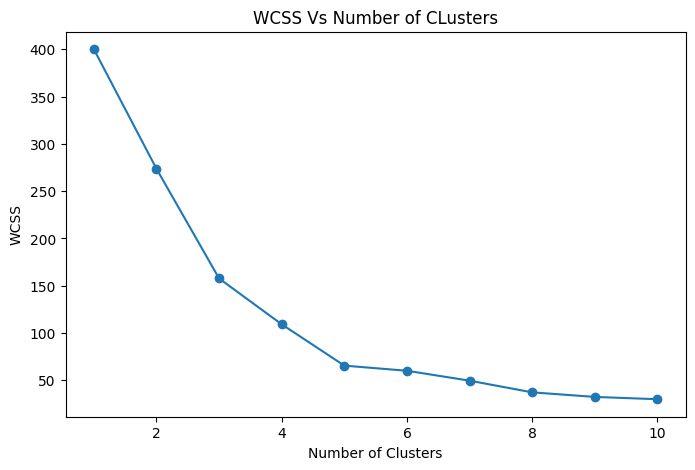

In [11]:
# Plotting the Elbow graph
plt.figure(figsize=(8,5))
plt.plot(range(1,11), wcss, marker="o")
plt.title("WCSS Vs Number of CLusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [12]:
# Apply KMeans with optimal clusters (from the above graph, 5 clusters are optimal)
kmeans=KMeans(n_clusters=5, init="k-means++", random_state=42)
clusters=kmeans.fit_predict(X_scaled)

In [13]:
# Adding the Cluster column to the original Dataset
data['Cluster'] = clusters

#**6. Visualizing the Clusters**

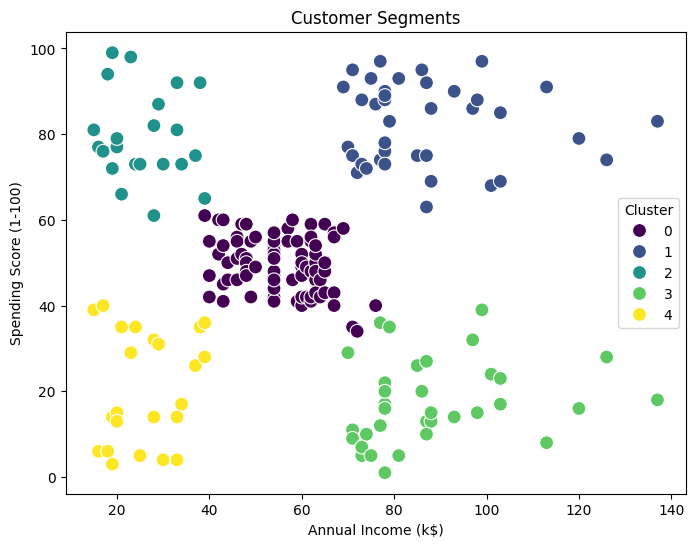

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=data['Annual Income (k$)'], y=data['Spending Score (1-100)'], hue=data['Cluster'], palette="viridis", s=100)
plt.title("Customer Segments")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend(title="Cluster")
plt.show()

In [15]:
# Calculate average income and spending score for each cluster
cluster_summary = data.groupby('Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()

# Function to label each cluster based on avg income and spending
def label_cluster(row):
    income = row['Annual Income (k$)']
    spending = row['Spending Score (1-100)']

    if income >= 70 and spending >= 60:
        return "High Income - High Spending (VIP)"
    elif income >= 70 and spending < 40:
        return "High Income - Low Spending (Target)"
    elif income < 40 and spending >= 60:
        return "Low Income - High Spending (Careful)"
    elif income < 40 and spending < 40:
        return "Low Income - Low Spending (Ignore)"
    else:
        return "Medium Income - Medium Spending (Average)"

cluster_summary['Label'] = cluster_summary.apply(label_cluster, axis=1)
print(cluster_summary)

         Annual Income (k$)  Spending Score (1-100)  \
Cluster                                               
0                 55.296296               49.518519   
1                 86.538462               82.128205   
2                 25.727273               79.363636   
3                 88.200000               17.114286   
4                 26.304348               20.913043   

                                             Label  
Cluster                                             
0        Medium Income - Medium Spending (Average)  
1                High Income - High Spending (VIP)  
2             Low Income - High Spending (Careful)  
3              High Income - Low Spending (Target)  
4               Low Income - Low Spending (Ignore)  


#**7. For Deploying the Model through Streamlit**

In [16]:
#Save the trained model
with open("kmeans_model.pkl", "wb") as f:
  pickle.dump(kmeans, f)

# Assuming 'kmeans' is the trained model, and 'scaler' is the StandardScaler used on features
with open("scaler.pkl", "wb") as f:
  pickle.dump(scaler, f)

In [17]:
from google.colab import files
files.download("kmeans_model.pkl")
files.download("scaler.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Code for Streamlit App
code = '''
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Load trained model and scaler
model = pickle.load(open('model/kmeans_model.pkl', 'rb'))
scaler = pickle.load(open('model/scaler.pkl', 'rb'))

# Behavior labeling function
def get_behavior_label(income, spending):
    if income >= 70 and spending >= 60:
        return "High Income, High Spending"
    elif income >= 70 and spending < 40:
        return "High Income, Low Spending"
    elif income < 40 and spending >= 60:
        return "Low Income, High Spending"
    else:
        return "Low Income, Low Spending"

st.set_page_config(page_title="Customer Clustering App", layout="wide")
st.title("🛍️ Customer Segmentation and Behavior Analysis")

option = st.sidebar.selectbox(
    "Choose an action",
    ["Dataset Summary", "Behavior-Based Filtering", "Predict Single Customer", "Predict from CSV"]
)

if option == "Dataset Summary":
    st.header("📊 Dataset Summary")
    uploaded_file = st.file_uploader("Upload Customer Dataset (CSV)", type=['csv'])
    if uploaded_file:
        df = pd.read_csv(uploaded_file)
        st.write("Preview of Dataset:")
        st.dataframe(df.head())
        st.write("Dataset Description:")
        st.write(df.describe())
        st.write("Missing Values:")
        st.write(df.isnull().sum())

elif option == "Behavior-Based Filtering":
    st.header("🎯 Filter Customers by Behavior Type")
    uploaded_file = st.file_uploader("Upload Customer Dataset (CSV)", type=['csv'])
    if uploaded_file:
        df = pd.read_csv(uploaded_file)
        # Assuming dataset has 'Annual Income (k$)' and 'Spending Score (1-100)' columns
        df['Behavior'] = df.apply(lambda row: get_behavior_label(row['Annual Income (k$)'], row['Spending Score (1-100)']), axis=1)
        behavior = st.selectbox("Select Behavior Type:", df['Behavior'].unique())
        st.dataframe(df[df['Behavior'] == behavior])

elif option == "Predict Single Customer":
    st.header("🧍 Predict Single Customer Cluster")
    gender = st.selectbox("Gender", ["Male", "Female"])
    income = st.number_input("Annual Income (k$)", 0, 150, 50)
    spending = st.number_input("Spending Score (1-100)", 0, 100, 50)
    if st.button("Predict Cluster"):
        gender_num = 1 if gender == "Male" else 0
        features = scaler.transform([[gender_num, income, spending]])
        cluster = model.predict(features)[0]
        behavior = get_behavior_label(income, spending)
        st.success(f"Predicted Cluster: {cluster} ({behavior})")

elif option == "Predict from CSV":
    st.header("📂 Predict Customer Clusters from File")
    uploaded_file = st.file_uploader("Upload Customer Dataset (CSV)", type=['csv'])
    if uploaded_file:
        df = pd.read_csv(uploaded_file)
        features = df[['Gender', 'Annual Income (k$)', 'Spending Score (1-100)']]
        features['Gender'] = features['Gender'].map({'Male':1, 'Female':0})
        scaled_features = scaler.transform(features)
        df['Cluster'] = model.predict(scaled_features)
        df['Behavior'] = df.apply(lambda row: get_behavior_label(row['Annual Income (k$)'], row['Spending Score (1-100)']), axis=1)
        st.write("Predicted Dataset:")
        st.dataframe(df)
        csv = df.to_csv(index=False).encode('utf-8')
        st.download_button("Download Predictions as CSV", data=csv, file_name="customer_predictions.csv", mime='text/csv')

# 📊 Visualization section (Optional for Dataset Summary or CSV Upload)
if option in ["Dataset Summary", "Predict from CSV"] and uploaded_file:
    try:
        fig, ax = plt.subplots()
        scatter = ax.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], c=df['Cluster'], cmap='viridis', alpha=0.7)
        ax.set_xlabel("Annual Income (k$)")
        ax.set_ylabel("Spending Score (1-100)")
        ax.set_title("Customer Segments Visualization")
        plt.colorbar(scatter, ax=ax, label='Cluster')
        st.pyplot(fig)
    except Exception as e:
        st.warning("Visualization could not be generated. Ensure 'Annual Income (k$)', 'Spending Score (1-100)' and 'Cluster' columns exist.")

'''
with open("customer_segmentation_app.py", "w") as f:
  f.write(code)

In [19]:
from google.colab import files
files.download("customer_segmentation_app.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>